#### Preamble

Use the environment `shrec`

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

### Benchmark against the ARACNE Algorithm


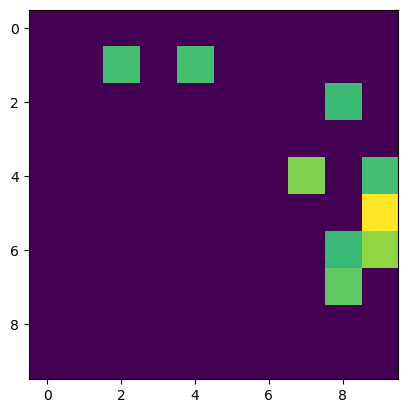

In [19]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler

class ARACNE:
    """
    Optimized ARACNE algorithm for inferring gene regulatory networks.

    The approach here is based on the existing open-source implementation:
    https://github.com/rugrag/ARACNE-gene-network-inference
    However, it has been modified to use vectorized operations and faster KDE

    Parameters:
        n_permutations (int): Number of permutations to use for the permutation test.
        random_state (int): Random seed.

    Attributes:
        count_matrix (np.ndarray): Count matrix of shape (n_samples, n_genes).
        n_samples (int): Number of samples.
        n_genes (int): Number of genes.
        mutual_info_matrix (np.ndarray): Mutual information matrix of shape 
            (n_genes, n_genes).
        mutual_info_matrix_alternative (np.ndarray): Null distribution of the 
            mutual information matrix of shape (n_permutations, n_genes, n_genes).
        mutual_info_matrix_filtered (np.ndarray): Filtered mutual information 
            matrix of shape (n_genes, n_genes).
        network (np.ndarray): Inferred network as an upper triangular affinity
            matrix of shape (n_genes, n_genes).

    References:
        [1] Margolin, Adam A., et al. BMC Bioinformatics. Vol. 7. 2006.
    """
    def __init__(self, n_permutations=5, random_state=None):
        self.n_permutations = n_permutations
        self.random_state = random_state
        np.random.seed(self.random_state)

    def p_kde(self, x, X, h):
        kde = gaussian_kde(X, bw_method=h)
        return kde(x)[0]

    def kernel_mi(self, X, Y):
        """
        Calculate the mutual information between two variables using kernel density 
        estimation.
        """
        d = 2
        nx = len(X)
        hx = (4 / (d + 2)) ** (1 / (d + 4)) * nx ** (-1 / (d + 4))

        # Compute KDE for X, Y, and their joint distribution
        px = np.array([self.p_kde(X[i], X, hx) for i in range(nx)])
        py = np.array([self.p_kde(Y[i], Y, hx) for i in range(nx)])
        joint_data = np.vstack((X, Y))
        pxy = np.array([self.p_kde(np.array([X[i], Y[i]]), joint_data, hx) for i in range(nx)])

        # Calculate mutual information
        mi_estimation = np.log(pxy / (px * py))
        return np.mean(mi_estimation)
    
    def kernel_mi(self, X, Y, d=2):
        nx = len(X)
        hx = (4 / (d + 2)) ** (1 / (d + 4)) * nx ** (-1 / (d + 4))

        # Compute KDE for X, Y, and their joint distribution
        kde_X = gaussian_kde(X, bw_method=hx)
        px = kde_X(X)
        kde_Y = gaussian_kde(Y, bw_method=hx)
        py = kde_Y(Y)
        joint_data = np.array([X, Y])
        kde_joint = gaussian_kde(joint_data, bw_method=hx)
        pxy = kde_joint(joint_data)

        # Calculate mutual information
        mi_estimation = np.log(pxy / (px * py))
        return np.mean(mi_estimation)

    def calculate_mutual_info_matrix(self, X):
        """
        Calculate the mutual information matrix for a given data matrix. This 
        calculation is symmetric, so only the upper triangular portion of the
        matrix is stored.
        """
        d = X.shape[1]
        mutual_info_matrix = np.zeros((d, d))
        for ix in np.arange(d):
            for jx in np.arange(ix + 1, d):
                mutual_info_matrix[ix, jx] = self.kernel_mi(X[:, ix], X[:, jx])
        return mutual_info_matrix

    def permutation_test(self):
        """
        Perform a permutation test to estimate the null distribution of the
        mutual information matrix.
        """
        mutual_info_matrix_alternative = np.zeros((self.n_permutations, self.n_genes, self.n_genes))
        for n in range(self.n_permutations):
            shuffled_X = np.apply_along_axis(np.random.permutation, 1, self.count_matrix)
            mutual_info_matrix_alternative[n, ...] = self.calculate_mutual_info_matrix(shuffled_X)
        return np.mean(mutual_info_matrix_alternative, axis=0)

    def filter_mi(self):
        """
        Filter the mutual information matrix based on the alternative
        permutation test.
        """
        mutual_info_matrix_filtered = np.copy(self.mutual_info_matrix)
        I_0 = np.amax(self.mutual_info_matrix_alternative)
        mutual_info_matrix_filtered[mutual_info_matrix_filtered < I_0] = 0
        return mutual_info_matrix_filtered

    def data_processing_inequality(self, M, i, j, k):
        """
        The Data Processing Inequality (DPI) can be used to filter out edges that
        result from indirect relationships, where X -> Y -> Z induces a non-zero
        mutual information between X and Z.

        The criterion is that if I[i, k] < min(I[i, j], I[j, k]),
        then the edge from i to k is filtered.
        """
        dic = {0: (i, j), 1: (i, k), 2: (j, k)}
        dpi_list = [M[i, j], M[i, k], M[j, k]]
        idx = np.argmin(dpi_list)
        return dic[idx]

    def filter_loops(self, M):
        """
        Filter out loops from the mutual information matrix based on the
        Data Processing Inequality (DPI).
        """
        set_to_zero = []
        for i in range(M.shape[0]):
            idx_j = np.where(M[i] != 0)[0]  # Indices where M[i] is non-zero
            for j in idx_j:
                idx_k = np.where(M[j] != 0)[0]  # Indices where M[j] is non-zero
                valid_k = idx_k[M[i, idx_k] != 0]
                if valid_k.size > 0:
                    set_to_zero.extend(
                        [self.data_processing_inequality(M, i, j, k) for k in valid_k]
                    )

        if set_to_zero:
            set_to_zero = np.array(set_to_zero).T
            M[tuple(set_to_zero)] = 0
        
        return M

    def fit_transform(self, count_matrix):
        """
        Fit the ARACNE algorithm to the count matrix and return the inferred
        network as an upper triangular affinity matrix.
        """
        self.count_matrix = count_matrix
        self.n_samples, self.n_genes = count_matrix.shape
        
        # Standardize the input matrix and calculate the mutual information
        scaler = StandardScaler()
        count_matrix = scaler.fit_transform(count_matrix)
        self.mutual_info_matrix = self.calculate_mutual_info_matrix(count_matrix)
        
        # Perform the permutation test to estimate the null distribution of
        # the mutual information matrix
        self.mutual_info_matrix_alternative = self.permutation_test()

        # Filter the mutual information matrix based on the alternative
        # permutation test
        self.mutual_info_matrix_filtered = self.filter_mi()
        
        # Apply the Data Processing Inequality (DPI) to filter out loops
        self.network = self.filter_loops(self.mutual_info_matrix_filtered)
        
        return self.network
    
aracne = ARACNE(n_permutations=5, random_state=0)

np.random.seed(1)
X = np.random.rand(100, 10)
X0 = np.copy(X)
network = aracne.fit_transform(X)
plt.imshow(network)

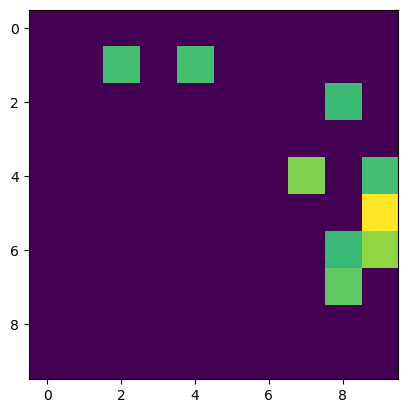

In [9]:
aracne = ARACNE(n_permutations=5, random_state=0)

np.random.seed(1)
X = np.random.rand(100, 10)
X0 = np.copy(X)
network = aracne.fit_transform(X)
plt.imshow(network)

In [123]:
import glob
all_datasets = sorted(glob.glob("data/combination_regulation/*"))
all_seed_vals = [int(x.split("_")[-1].split(".")[0]) for x in all_datasets]

for seed_val in all_seed_vals[-100:]:

    ## Load the dataset, the true driver, and the indices into the original regulatory network
    y_driver = np.load(f"data/combination_regulation/y_driver_{seed_val}.npy", allow_pickle=True)
    X_measure = np.load(f"data/combination_regulation/X_measure_{seed_val}.npy", allow_pickle=True)
    true_indices = np.load(f"data/combination_regulation/simplex_indices_{seed_val}.npy", allow_pickle=True)[1:]

    aracne = ARACNE(n_permutations=5, random_state=0)

    network = aracne.fit_transform(X)

    top_indices = np.argsort(np.sum(np.abs(network), axis=1))[::-1]

    # save indices to text file
    np.savetxt(f"./dump_results/aracne_output/indices_{seed_val}.txt", top_indices, fmt="%d")

    


array([4, 6])

In [21]:
import networkx as nx
from scipy.sparse import csr_matrix
import numpy as np

class GeneNetwork:
    def __init__(self, filepath, delimiter='\t', header=True, directed=False):
        """
        Initializes the GeneNetwork by reading the file and creating a graph.
        
        Parameters:
        - filepath (str): Path to the gene interaction file.
        - delimiter (str): Delimiter used in the file (default is tab).
        - header (bool): Indicates if the file has a header row (default is True).
        - directed (bool): Specifies if the graph is directed (default is False).
        """
        self.filepath = filepath
        self.delimiter = delimiter
        self.header = header
        self.directed = directed
        self.graph = self._create_graph()
        self.adj_matrix = self._create_adjacency_matrix()
    
    def _create_graph(self):
        """
        Reads the file and creates a NetworkX graph.
        
        Returns:
        - G (networkx.Graph or networkx.DiGraph): The gene interaction graph.
        """
        G = nx.DiGraph() if self.directed else nx.Graph()
        
        with open(self.filepath, 'r') as file:
            for idx, line in enumerate(file):
                if self.header and idx == 0:
                    continue  # Skip header line
                parts = line.strip().split(self.delimiter)
                if len(parts) != 2:
                    continue  # Skip malformed lines
                tf, tg = parts
                G.add_edge(tf, tg)
        
        return G
    
    def _create_adjacency_matrix(self):
        """
        Creates the adjacency matrix of the graph as a SciPy sparse CSR matrix.
        
        Returns:
        - adj_matrix (scipy.sparse.csr_matrix): The adjacency matrix in CSR format.
        """
        # Using NetworkX's built-in function to create a sparse adjacency matrix
        adj_matrix = nx.to_scipy_sparse_array(
            self.graph,
            format='csr',
            dtype=np.int8  # Use a small integer type to save memory
        )
        return adj_matrix
    

    def __str__(self):
        """
        Prints basic information about the graph.
        """
        return (f"Directed: {self.directed}\n"
                f"Number of nodes: {self.graph.number_of_edges()}\n"
                f"Number of edges: {self.graph.number_of_edges()}\n"
                f"Adjacency matrix stored as SciPy CSR sparse matrix with shape {self.adj_matrix.shape}")
    
    def get_node_list(self):
        """
        Returns a sorted list of nodes in the graph.
        
        Returns:
        - nodes (list): Sorted list of node identifiers.
        """
        return sorted(self.graph.nodes())
    
    def get_edges(self):
        """
        Returns a list of edges in the graph.
        
        Returns:
        - edges (list of tuples): List containing edge tuples (u, v).
        """
        return list(self.graph.edges())
    
    def find_shortest_path(self, source, target):
        """
        Finds the shortest path between two nodes using NetworkX's shortest path algorithms.
        
        Parameters:
        - source (str): Source node.
        - target (str): Target node.
        
        Returns:
        - path (list): List of nodes representing the shortest path.
        """
        try:
            path = nx.shortest_path(self.graph, source=source, target=target)
            return path
        except nx.NetworkXNoPath:
            print(f"No path between {source} and {target}.")
            return None
        except nx.NodeNotFound as e:
            print(e)
            return None
    
    def degree_distribution(self):
        """
        Computes the degree distribution of the graph.
        
        Returns:
        - degree_count (dict): Dictionary mapping degree to number of nodes with that degree.
        """
        degrees = dict(self.graph.degree())
        degree_count = {}
        for degree in degrees.values():
            degree_count[degree] = degree_count.get(degree, 0) + 1
        return degree_count
    
    def get_node_degrees(self):
        """
        Computes the degree of each node in the graph.
        
        For undirected graphs, returns the degree.
        For directed graphs, returns both in-degree and out-degree.
        
        Returns:
        - degrees (dict): 
            - If undirected: {node: degree}
            - If directed: {node: {'in_degree': x, 'out_degree': y}}
        """
        degrees = {}
        if self.directed:
            in_degrees = dict(self.graph.in_degree())
            out_degrees = dict(self.graph.out_degree())
            for node in self.graph.nodes():
                degrees[node] = {
                    'in_degree': in_degrees.get(node, 0),
                    'out_degree': out_degrees.get(node, 0)
                }
        else:
            degrees = dict(self.graph.degree())
        return degrees

# Example Usage
if __name__ == "__main__":
    # Assuming the file is named 'gene_network.txt' and is in the current directory
    filepath = '/Users/william/program_repos/dygene/data/yeast_transcriptional_network_Balaji2006.txt'
    
    # Initialize the GeneNetwork (assuming undirected graph)
    gene_network = GeneNetwork(filepath, directed=False)
    
    # Display basic information
    gene_network.display_basic_info()
    
    # Access the NetworkX graph
    G = gene_network.get_networkx_graph()
    print("Nodes:", list(G.nodes())[:10], "...")  # Display first 10 nodes
    print("Edges:", list(G.edges())[:10], "...")  # Display first 10 edges
    
    # Get adjacency matrix as SciPy sparse matrix
    adj_sp = gene_network.get_adjacency_matrix_sparse()
    print("Adjacency Matrix (SciPy Sparse):")
    print(adj_sp)
    
    # Example: Find shortest path between two genes
    source_gene = 'YAL051W'
    target_gene = 'YER015W'
    path = gene_network.find_shortest_path(source_gene, target_gene)
    if path:
        print(f"Shortest path from {source_gene} to {target_gene}: {path}")
    
    # Example: Get degree distribution
    degree_dist = gene_network.degree_distribution()
    print("Degree Distribution:", degree_dist)
    
    # Example: Get degrees of all nodes
    node_degrees = gene_network.get_node_degrees()
    # Display degrees of first 10 nodes
    first_10_nodes = list(gene_network.get_node_list())[:10]
    for node in first_10_nodes:
        print(f"Degrees for node {node}: {node_degrees[node]}")


Directed: False
Number of nodes: 4441
Number of edges: 12864
Adjacency matrix stored as SciPy CSR sparse matrix with shape (4441, 4441)
Nodes: ['YAL051W', 'YAL016W', 'YAL034WA', 'YAL035CA', 'YAL035W', 'YAL036C', 'YBL089W', 'YBR019C', 'YBR020W', 'YBR127C'] ...
Edges: [('YAL051W', 'YAL016W'), ('YAL051W', 'YAL034WA'), ('YAL051W', 'YAL035CA'), ('YAL051W', 'YAL035W'), ('YAL051W', 'YAL036C'), ('YAL051W', 'YBL089W'), ('YAL051W', 'YBR019C'), ('YAL051W', 'YBR020W'), ('YAL051W', 'YBR127C'), ('YAL051W', 'YBR150C')] ...
Adjacency Matrix (SciPy Sparse):
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	1
  (0, 16)	1
  (0, 17)	1
  (0, 18)	1
  (0, 19)	1
  (0, 20)	1
  (0, 21)	1
  (0, 22)	1
  (0, 23)	1
  (0, 24)	1
  (0, 25)	1
  :	:
  (4439, 3287)	1
  (4440, 94)	1
  (4440, 103)	1
  (4440, 106)	1
  (4440, 124)	1
  (4440, 126)	1
  (4440, 169)	1
  (4440, 179)	1
  (4440, 182)	1
  (4440, 419